## Make a CVF based on concentration of the host halos

Import everything

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
from astropy.io import ascii
from astropy.table import *
import scipy
from scipy import stats
from scipy import ndimage
import math
np.set_printoptions(threshold='nan')
%matplotlib inline

This function calculates the mean vmax across all of the host halos. This is used as the vmax for the Milky Way because sources vary significantly on what vmax for the MW is.

In [12]:
def get_mean_vmax():
    hostvmaxs = []
    rootdir = '/Users/catherinefielder/Documents/Research_Halos/HaloDetail'
    for subdir, dirs, files in os.walk(rootdir):
        head,tail = os.path.split(subdir)
        for file in files:
            if file.endswith('_columnsadded_final'):
                values = ascii.read(os.path.join(subdir, file), format = 'commented_header') #Get full path and access file
                hostvmax=values[1]['host_vmax']
                hostvmaxs = np.append(hostvmaxs, hostvmax)
            sumvmax = np.sum(hostvmaxs)
            meanvmax = np.divide(sumvmax,len(hostvmaxs))

    return meanvmax

The following function deals with the Nan values I have for the detection efficiency of some of the subhalos of the Milky Way.

In [13]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

This function calculates the weight of the detection of each Milky Way subhalo that there is data on, and then adds it to make it cumulative. This is essentially a proxy for scaling the number of subhalos of the Milky Way in order to accound for sky coverage and detection. It also returns the fractional velocities of the subhalos for plotting.

In [14]:
def interpolateMW():
    vmaxMW1 = get_mean_vmax()
    vmaxSat = np.array([13.0,20.5,14.0,12.8,16.4,5.0,16.0,15.7,9.1,10.0,11.8,11.0,11.0,8.3,20.0,17.3,11.8,11.4,17.8,40.0,92.0,60.0])
    efficiency = np.array([0.78,1.0,0.56,1.0,1.0,0.79,0.76,1.0,0.97,1.0,0.99,0.47,0.72,0.99,np.nan,np.nan,np.nan,np.nan,np.nan,1.0,1.0,1.0])
    #20.0,17.3,11.8,11.4,17.8
    vfracMW = np.divide(vmaxSat,vmaxMW1)
    coupled = zip(vfracMW,efficiency)
    coupled = sorted(coupled, key=lambda (x,y):(x,y))
    sortvmax,sorteff = zip(*coupled)
    sortvmax = np.array(sortvmax)
    sorteff = np.array(sorteff)    

    nans, x= nan_helper(sorteff)
    f = scipy.interpolate.interp1d(x(~nans), sorteff[~nans], kind='linear')
    sorteff = f(sortvmax)

    ones = np.ones(len(sorteff))
    weight = np.array(np.divide(ones,sorteff))
    
    summed = np.zeros(len(sortvmax))
    summed[0] = weight[0]
    for m in range(1,len(weight)):
        summed[m] = summed[m-1]+weight[m]
   
    index = np.arange(len(vfracMW))
    rindex = len(index)-index 
    
    return sorted(sortvmax,reverse=True),summed

The following function calculates the boundary of each quartile based on concentration.

In [15]:
def get_percentile():
    rootdir = '/Users/catherinefielder/Documents/Research_Halos/HaloDetail'
    cs = []
    for subdir, dirs, files in os.walk(rootdir):
        head,tail = os.path.split(subdir)
        for file in files:
            if file.endswith('_columnsadded_final'):
                values = ascii.read(os.path.join(subdir, file), format = 'commented_header') #Get full path and access file
                c=values[1]['host_c']                                                  #Grab the host spin
                cs = np.append(cs, c) 
    twentyfifth = np.percentile(cs, 25)
    fifty = np.percentile(cs, 50)
    seventyfifth = np.percentile(cs, 75)
    return twentyfifth, fifty, seventyfifth 

The following function puts each of the hosts into a quartile and then makes plots. Please see comments for details.

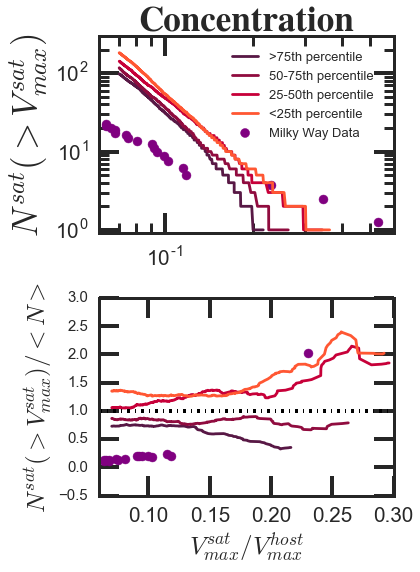

In [17]:
def plotting():
    #Define variables
    twentyfifth, fifty, seventyfifth = get_percentile()
    vfrac25s = []
    vfrac50s = []
    vfrac75s = []
    vfracxs = []
    vfracs = []
    Nsubs = []
    i=0
    j=0
    k=0
    l=0
    m=0
    rootdir = '/Users/catherinefielder/Documents/Research_Halos/HaloDetail'
    for subdir, dirs, files in os.walk(rootdir):
        head,tail = os.path.split(subdir)
        for file in files:
            if file.endswith('_columnsadded_final'):
                values = ascii.read(os.path.join(subdir, file), format = 'commented_header') #Get full path and access file
                #Resolution limit
                whlimit = np.where((values['vmax(16)']<100) & (values['vmax(16)']>10))
                #Get the concentration and vmax,host on a host by host basis
                c=values[1]['host_c']
                hostvmax=values[1]['host_vmax'] 
                #Place each host into a quartile
                if c >= seventyfifth:
                    vfrac75 = np.divide(np.array((values[whlimit]['vmax(16)'])),hostvmax)
                    vfrac75s = np.append(vfrac75s, vfrac75)
                    i+=1                    
                if c >= fifty and c < seventyfifth:
                    vfrac50 = np.divide(np.array((values[whlimit]['vmax(16)'])),hostvmax)
                    vfrac50s = np.append(vfrac50s, vfrac50)
                    j+=1
                if  c < fifty and c >= twentyfifth:
                    vfrac25 = np.divide(np.array((values[whlimit]['vmax(16)'])), hostvmax)                             
                    vfrac25s = np.append(vfrac25s, vfrac25)
                    k+=1
                if c < twentyfifth:
                    vfracx = np.divide(np.array((values[whlimit]['vmax(16)'])), hostvmax)
                    vfracxs = np.append(vfracxs, vfracx)
                    l+=1
                #Get vfrac for all of the subhalos together
                vfrac = np.divide(np.array((values[whlimit]['vmax(16)'])), hostvmax)
                vfracs = np.append(vfracs, vfrac)
                Nsub = len(vfrac)
                Nsubs = np.append(Nsubs, Nsub)
                m+=1
    
    #Calculate the Ntotals >Vmax for each quartile, and divide by number of subhalos in the quartile
    #This makes it cumulative
    sorted_top_percentile = np.sort(vfrac75s)
    top_percentile_index = np.arange(len(sorted_top_percentile))
    rtop_percentile_index = len(top_percentile_index)-top_percentile_index
    Ntotals75 = (np.divide(rtop_percentile_index,i))
    #Get rid of where we get 0 subhalos and points below the resolution limit - using .07 
    cutoff75 = np.where([s for s in sorted_top_percentile if s < 0.07])
    final_vfrac75s = np.delete(sorted_top_percentile,cutoff75)
    sorted_Ntotals75 = np.delete(Ntotals75,cutoff75)
    final_Ntotals75 = [q for q in sorted_Ntotals75 if q != 0]
    cutoffN75 = np.where(sorted_Ntotals75==0)
    fin_vfrac75s = np.delete(final_vfrac75s,cutoffN75)
    fin_vfrac75s = np.array(fin_vfrac75s)
    final_Ntotals75 = np.array(final_Ntotals75)
        
    sorted_2_percentile = np.sort(vfrac50s)    
    second_percentile_index = np.arange(len(sorted_2_percentile))
    rsecond_percentile_index = len(second_percentile_index)-(second_percentile_index)
    Ntotals50 = np.divide(rsecond_percentile_index,j)
    cutoff50 = np.where([s for s in sorted_2_percentile if s < 0.07]) 
    final_vfrac50s=[s for s in sorted_2_percentile if s >= 0.07] 
    sorted_Ntotals50 = np.delete(Ntotals50,cutoff50)  
    final_Ntotals50 = [q for q in sorted_Ntotals50 if q != 0]
    cutoffN50 = np.where(sorted_Ntotals50==0)
    fin_vfrac50s = np.delete(final_vfrac50s,cutoffN50)
    fin_vfrac50s = np.array(fin_vfrac50s)
    final_Ntotals50 = np.array(final_Ntotals50)   
    
    sorted_3_percentile = sorted(vfrac25s)    
    third_percentile_index = np.arange(len(sorted_3_percentile))
    rthird_percentile_index = len(third_percentile_index)-(third_percentile_index)
    Ntotals25 = (np.divide(rthird_percentile_index,k))
    cutoff25 = np.where([s for s in sorted_3_percentile if s < 0.07])
    final_vfrac25s = np.delete(sorted_3_percentile,cutoff25)
    sorted_Ntotals25 = np.delete(Ntotals25,cutoff25)
    final_Ntotals25 = [q for q in sorted_Ntotals25 if q != 0]
    cutoffN25 = np.where(sorted_Ntotals25==0)
    fin_vfrac25s = np.delete(final_vfrac25s,cutoffN25)
    fin_vfrac25s = np.array(fin_vfrac25s)
    final_Ntotals25 = np.array(final_Ntotals25)
    
    sorted_last_percentile = sorted(vfracxs)    
    last_percentile_index = np.arange(len(sorted_last_percentile))
    rlast_percentile_index = len(last_percentile_index)-(last_percentile_index)
    Ntotalsx = (np.divide(rlast_percentile_index,l))
    cutoffx = np.where([s for s in sorted_last_percentile if s < 0.07])
    final_vfracxs = np.delete(sorted_last_percentile,cutoffx)
    sorted_Ntotalsx = np.delete(Ntotalsx,cutoffx)
    final_Ntotalsx = [q for q in sorted_Ntotalsx if q != 0]
    cutoffNx = np.where(sorted_Ntotalsx==0)
    fin_vfracxs = np.delete(final_vfracxs,cutoffNx)
    fin_vfracxs = np.array(fin_vfracxs)
    final_Ntotalsx = np.array(final_Ntotalsx)
    
    #Do the same for 
    sortedv = sorted(vfracs)    
    index = np.arange(len(sortedv))
    rindex = len(index)-(index)
    Ntotals = (np.divide(rindex,m))
    cutoff = np.where([s for s in sortedv if s < 0.07])
    final_vfracs = np.delete(sortedv,cutoff)
    sorted_Ntotals = np.delete(Ntotals,cutoff)
    final_Ntotals = [q for q in sorted_Ntotals if q != 0]
    cutoffN = np.where(sorted_Ntotals==0)
    fin_vfracs = np.delete(final_vfracs,cutoffN)
    fin_vfracs = np.array(fin_vfracs)
    final_Ntotals = np.array(final_Ntotals)
     
    #Grad the Milky Way data points
    vfracMW, rindex = interpolateMW() 
     
    #Interpolate a function for all values with evenly space knots
    t = np.arange(min(fin_vfracs),max(fin_vfracs),0.01) 
    f = scipy.interpolate.LSQUnivariateSpline(fin_vfracs, (final_Ntotals), t[1:-1], bbox=[fin_vfracs[0],fin_vfracs[-1]])
   
    #PLOTTING SECTION
    #First make the CVF plot
    fig = plt.figure(figsize=(10,8))
    #Gridspec makes it easy to have two plots in one figure
    gs = gridspec.GridSpec(2,1, width_ratios=[4,4])
    gs.update(left=0.1, right=0.9, hspace=0.25)
    axis_font = {'fontname':'STIXGeneral','size':'35', 'weight':'bold'}
    ax2 = fig.add_subplot(gs[0])
    plt.scatter(vfracMW,rindex,s=80,color='purple',label='Milky Way Data')
    plt.plot(fin_vfrac75s,final_Ntotals75,color='#581845',label='>75th percentile')
    plt.plot(fin_vfrac50s,final_Ntotals50,color='#900C3F',label='50-75th percentile')
    plt.plot(fin_vfrac25s,final_Ntotals25,color='#C70039',label='25-50th percentile')
    plt.plot(fin_vfracxs,final_Ntotalsx,color='#FF5733',label='<25th percentile')
    plt.setp(ax2.spines.values(), linewidth=3) 
    plt.xlim(xmin=0.06,xmax=0.6)
    plt.ylim(ymin=0.9, ymax=300) 
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('$N^{sat}(>V^{sat}_{max})$',**axis_font)
    plt.title('Concentration', **axis_font)
    ax2.get_yaxis().set_tick_params(which='both', direction='in')
    ax2.get_xaxis().set_tick_params(which='both', direction='in')

    plt.legend(bbox_to_anchor=(0.97,0.98),loc='upper right',prop={'size':13})
    ax = fig.add_subplot(gs[1])
    axis_font = {'fontname':'STIXGeneral','size':'25', 'weight':'bold'}
    
    #Now we make the residual plots
    #Calculate the residual from our function of all values
    fraction75s=[]
    for i in range(0,len(final_Ntotals75)): 
        fraction75 = np.divide(final_Ntotals75[i],(f(fin_vfrac75s[i])))
        fraction75s = np.append(fraction75s,(fraction75))
    #Exclude crazy values due to small number of subhalos at larger velocities
    delete75 = np.where(fin_vfrac75s >= 0.3)
    fin_vfrac75s = np.delete(fin_vfrac75s, delete75)
    fraction75s = np.delete(fraction75s, delete75)
    #Smooth the residual
    fraction75s = scipy.ndimage.filters.uniform_filter(fraction75s, size=12)
    #Plot the residual
    plt.plot((fin_vfrac75s),(fraction75s),color='#581845')
    
    fraction50s=[]        
    for j in range(0,len(final_Ntotals50)): 
        fraction50 = np.divide(final_Ntotals50[j],(f(fin_vfrac50s[j])))
        fraction50s = np.append(fraction50s, fraction50)
    delete50 = np.where(fin_vfrac50s >= 0.3)
    fin_vfrac50s = np.delete(fin_vfrac50s, delete50)
    fraction50s = np.delete(fraction50s, delete50)
    fraction50s = scipy.ndimage.filters.uniform_filter(fraction50s, size=12)
    plt.plot(fin_vfrac50s, (fraction50s),color='#900C3F',label='50-75th percentile')
    
    fraction25s=[]        
    for k in range(0,len(final_Ntotals25)): 
        fraction25 = np.divide(final_Ntotals25[k],(f(fin_vfrac25s[k])))
        fraction25s = np.append(fraction25s, fraction25)
    delete25 = np.where(fin_vfrac25s >= 0.3)
    fin_vfrac25s = np.delete(fin_vfrac25s, delete25)
    fraction25s = np.delete(fraction25s, delete25)
    fraction25s = scipy.ndimage.filters.uniform_filter(fraction25s, size=12)
    plt.plot(fin_vfrac25s,(fraction25s),color='#C70039',label='25-50th percentile')
        
    fractionxs = []
    for l in range(0,len(final_Ntotalsx)): 
        fractionx = np.divide(final_Ntotalsx[l],(f(fin_vfracxs[l])))
        fractionxs = np.append(fractionxs, fractionx)
    deletex = np.where(fin_vfracxs >= 0.3)
    fin_vfracxs = np.delete(fin_vfracxs, deletex)
    fractionxs = np.delete(fractionxs, deletex)
    fractionxs = scipy.ndimage.filters.uniform_filter(fractionxs, size=12)
    plt.plot(fin_vfracxs,(fractionxs),color='#FF5733',label='<25th percentile')
        
    #Adds MW data points
    fractionMWs = []
    for m in range(0,len(rindex)):
        fractionMW = np.divide(rindex[m],(f(vfracMW[m])))
        fractionMWs = np.append(fractionMWs, fractionMW)
    plt.scatter(vfracMW, fractionMWs, label='Milky Way points', s=80, color='purple')

   
    plt.xlabel('$V_{max}^{sat}/V_{max}^{host}$', **axis_font)
    plt.ylabel('$N^{sat}(>V^{sat}_{max})/<N>$',**axis_font)
    plt.xlim(xmin=0.06,xmax=0.3)
    plt.ylim(ymin=-0.5,ymax=3.0)
    plt.tick_params(axis='y', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=8)
    plt.setp(ax.spines.values(), linewidth=3) 
    sns.set_style("whitegrid")
    sns.set(style='ticks', palette='Set2')
    sns.set_context("poster", font_scale=1.3)
    matplotlib.rcParams['xtick.major.size'] = 20
    matplotlib.rcParams['xtick.major.width'] = 4
    matplotlib.rcParams['xtick.minor.size'] = 10
    matplotlib.rcParams['xtick.minor.width'] = 3
    matplotlib.rcParams['ytick.major.size'] = 20
    matplotlib.rcParams['ytick.major.width'] = 4
    matplotlib.rcParams['ytick.minor.size'] = 10
    matplotlib.rcParams['ytick.minor.width'] = 3
    ax.get_yaxis().set_tick_params(which='both', direction='in')
    ax.get_xaxis().set_tick_params(which='both', direction='in')
    plt.axhline(y=1.0, linewidth = 4, color='k', linestyle='-.')
    gs.tight_layout(fig, rect=[0, 0, 1, 1], pad=0.4, w_pad=0.1, h_pad=0.5)
    plt.show()
    

plotting()